In [5]:
import sqlite3
import pandas as pd
import numpy as np

Query:

In [ ]:

conn = sqlite3.connect("cnpj_data.db")
cursor = conn.cursor()


cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas = cursor.fetchall()

conn.close()

print("Tabelas encontradas:", tabelas)


Tabelas encontradas: [('empresas',), ('estabelecimentos',), ('socios',)]


In [9]:


conn = sqlite3.connect("cnpj_data.db")
cursor = conn.cursor()

cursor.execute("SELECT COUNT(*) FROM estabelecimentos;")
total_registros = cursor.fetchone()[0]

conn.close()

print(f"Total de registros na tabela estabelecimentos: {total_registros}")


Total de registros na tabela estabelecimentos: 64547763


In [10]:
conn = sqlite3.connect("cnpj_data.db")
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(estabelecimentos);")
colunas = cursor.fetchall()

conn.close()

print("Colunas da tabela estabelecimentos:", colunas)


Colunas da tabela estabelecimentos: [(0, 'CNPJ', 'TEXT', 0, None, 0), (1, 'Ordem', 'TEXT', 0, None, 0), (2, 'DV', 'TEXT', 0, None, 0), (3, 'Matriz_Filial', 'TEXT', 0, None, 0), (4, 'Fantasia', 'TEXT', 0, None, 0), (5, 'Situacao_Cadastral', 'TEXT', 0, None, 0), (6, 'Data_SC', 'TEXT', 0, None, 0), (7, 'Motivo_SC', 'TEXT', 0, None, 0), (8, 'Data_inicio', 'TEXT', 0, None, 0), (9, 'CNAE_P', 'TEXT', 0, None, 0), (10, 'CNAE_S', 'TEXT', 0, None, 0), (11, 'UF', 'TEXT', 0, None, 0), (12, 'Municipio', 'TEXT', 0, None, 0), (13, 'DDD', 'TEXT', 0, None, 0), (14, 'Telefone', 'TEXT', 0, None, 0), (15, 'Email', 'TEXT', 0, None, 0), (16, 'Endereco', 'TEXT', 0, None, 0)]


In [ ]:

conn = sqlite3.connect("cnpj_data.db")
query_check_indexes = """
SELECT name, tbl_name FROM sqlite_master WHERE type='index';
"""
df_indexes = pd.read_sql(query_check_indexes, conn)
conn.close()
print("\nÍndices existentes no banco de dados:\n", df_indexes)



Índices existentes no banco de dados:
                           name          tbl_name
0  sqlite_autoindex_empresas_1          empresas
1            idx_cnpj_empresas          empresas
2    idx_cnpj_estabelecimentos  estabelecimentos
3              idx_cnpj_socios            socios


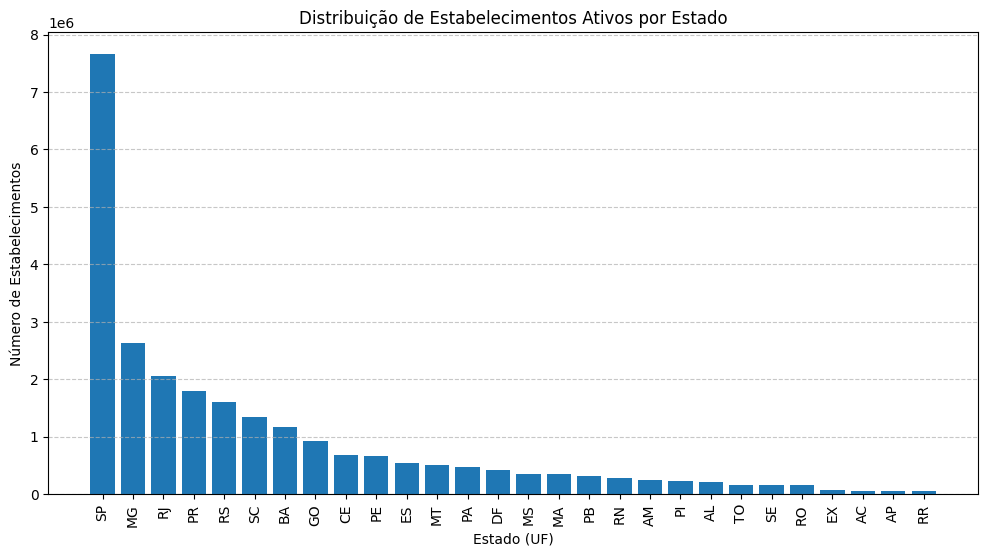

In [ ]:
import matplotlib.pyplot as plt

conn = sqlite3.connect("cnpj_data.db")


query = """
SELECT UF, COUNT(*) as total_estabelecimentos
FROM estabelecimentos
WHERE Situacao_Cadastral = '02'
GROUP BY UF
ORDER BY total_estabelecimentos DESC;
"""

df_empresas_por_estado = pd.read_sql(query, conn)


conn.close()


plt.figure(figsize=(12, 6))
plt.bar(df_empresas_por_estado["UF"], df_empresas_por_estado["total_estabelecimentos"])
plt.xlabel("Estado (UF)")
plt.ylabel("Número de Estabelecimentos")
plt.title("Distribuição de Estabelecimentos Ativos por Estado")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
import plotly.express as px


conn = sqlite3.connect("cnpj_data.db")


query_top_estados = """
SELECT UF, COUNT(*) as total_estabelecimentos
FROM estabelecimentos WHERE Situacao_Cadastral = '02'
GROUP BY UF
ORDER BY total_estabelecimentos DESC
LIMIT 7;
"""
df_top_estados = pd.read_sql(query_top_estados, conn)


top_estados = df_top_estados["UF"].tolist()


query_cnae_por_estado = f"""
SELECT e.UF, e.CNAE_P, COUNT(*) as total_estabelecimentos
FROM estabelecimentos e
WHERE e.Situacao_Cadastral = '02' AND e.UF IN ({','.join(['?']*len(top_estados))})
GROUP BY e.UF, e.CNAE_P
ORDER BY e.UF, total_estabelecimentos DESC
"""

df_cnae_por_estado = pd.read_sql(query_cnae_por_estado, conn, params=top_estados)
df_cnae_por_estado = df_cnae_por_estado.groupby('UF').apply(lambda x: x.nlargest(10, 'total_estabelecimentos')).reset_index(drop=True)
df_cnae_por_estado = df_cnae_por_estado.groupby(['UF', 'CNAE_P']).head(10).reset_index(drop=True)


df_cnae = pd.read_csv("cnae.csv", sep=";", dtype=str, encoding='utf-8')
df_cnae.columns = [col.strip().replace(" ", "_") for col in df_cnae.columns]
df_cnae_por_estado["CNAE_P"] = df_cnae_por_estado["CNAE_P"].astype(str)
df_cnae["CNAE"] = df_cnae["CNAE"].astype(str)


df_cnae_por_estado = df_cnae_por_estado.merge(df_cnae, left_on="CNAE_P", right_on="CNAE_N", how="left")
conn.close()


fig = px.bar(df_cnae_por_estado, x="UF", y="total_estabelecimentos", color="CNAE",
             title="Distribuição de CNAE Principal nos 7 Estados com Mais Estabelecimentos",
             labels={"UF": "Estado (UF)", "total_estabelecimentos": "Número de Estabelecimentos", "CNAE": "CNAE Principal"},
             barmode="stack")

fig.update_layout(xaxis_tickangle=-45)
fig.show()


C:\Users\joaom\AppData\Local\Temp\ipykernel_9556\2788636242.py:29: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [14]:
conn = sqlite3.connect("cnpj_data.db")
query_mult_estabelecimentos = """
SELECT CNPJ, COUNT(*) as total_estabelecimentos
FROM estabelecimentos
WHERE Situacao_Cadastral = '02'AND UF = 'SP' AND CNAE_P = '6204000'
GROUP BY CNPJ;
"""

df_mult_estabelecimentos = pd.read_sql(query_mult_estabelecimentos, conn)
conn.close()

df_mult_estabelecimentos = df_mult_estabelecimentos.sort_values("total_estabelecimentos", ascending=False)
df_mult_estabelecimentos.head(10)

,CNPJ,total_estabelecimentos
12896,44639864,10
2398,08733698,8
8178,35473014,5
491,02833315,5
26910,65699100,5
4226,18147500,4
3318,11880826,3
2565,09162855,3
1027,04232671,3
4358,19290938,3


In [15]:
conn = sqlite3.connect("cnpj_data.db")

query_mult_socios = """
SELECT s.CNPJ, e.Nome_Empresarial, COUNT(s.ID_Socio) as total_socios
FROM socios s
JOIN empresas e ON s.CNPJ = e.CNPJ
JOIN estabelecimentos est ON s.CNPJ = est.CNPJ
WHERE est.Situacao_Cadastral = '02' AND est.UF = 'SP' AND est.CNAE_P = '6204000'
GROUP BY s.CNPJ, e.Nome_Empresarial
ORDER BY total_socios DESC
LIMIT 1000;
"""

df_mult_socios = pd.read_sql(query_mult_socios, conn)

conn.close()

df_mult_socios.head(10)

,CNPJ,Nome_Empresarial,total_socios
0,33806738,PWC STRATEGY& DO BRASIL CONSULTORIA EMPRESARIA...,252
1,04055601,BECOMEX CONSULTORIA LTDA,156
2,04232671,NTT DATA BRASIL CONSULTORIA DE NEGOCIOS E TECN...,57
3,08733698,SONDA PROCWORK INFORMATICA LTDA,40
4,29717062,EVEREST TECNOLOGIA EM SISTEMAS LTDA,38
5,22164841,CRIARE CONSULTING SOFTWARE LTDA,36
6,07363764,SOLUCOES EM SOFTWARE E SERVICOS TTS LTDA,30
7,12667016,ECOM CONSULTORIA E TECNOLOGIA LTDA,30
8,44639864,HUBII BR LTDA,30
9,02833315,ENTERPRISE SERVICES BRASIL SERVICOS DE TECNOLO...,25


In [ ]:
import plotly.graph_objects as go
import networkx as nx

def get_cnpj_data(cnpj):
    conn = sqlite3.connect("cnpj_data.db") 
    
    query_main_empresa = """
    SELECT CNPJ, Nome_Empresarial
    FROM empresas
    WHERE CNPJ = ?;
    """
    df_empresa = pd.read_sql(query_main_empresa, conn, params=(cnpj,))


    query_socios = """
    SELECT CNPJ, Nome, CPF_CNPJ
    FROM socios
    WHERE CNPJ = ?;
    """

    df_socios = pd.read_sql(query_socios, conn, params=(cnpj,))

    conn.close()
    
    return df_empresa, df_socios

def get_relations_socios(cnpj_inicial, nome_socio, cpf):
    conn = sqlite3.connect("cnpj_data.db")
    query_double_socios = """
    SELECT CNPJ
    FROM socios
    WHERE CNPJ != ? AND Nome = ? AND CPF_CNPJ = ? ;
    """

    df_empresas_relacionadas = pd.read_sql(query_double_socios, conn, params=(cnpj_inicial, nome_socio, cpf))
    
    conn.close()
    return df_empresas_relacionadas

def list_data_layers(cnpj_inicial, max_camadas=3):
    from collections import deque

    fila = deque([(cnpj_inicial, 0)])
    
    cnpjs_visitados = set()
    socios_visitados = set()

    socios_set = set()
    empresas_set = set()

    while fila:
        cnpj_atual, camada = fila.popleft()
        if cnpj_atual in cnpjs_visitados or camada > max_camadas:
            continue

        empresas_set.add(cnpj_atual)
        df_empresa, df_socios = get_cnpj_data(cnpj_atual)

        for _, socio in df_socios.iterrows():
            nome_socio = socio["Nome"]
            cpf = socio["CPF_CNPJ"]
            chave_socio = (nome_socio, cpf)

            if chave_socio in socios_visitados:
                continue

            socios_visitados.add(chave_socio)
            socios_set.add(chave_socio)

            df_relacionadas = get_relations_socios(cnpj_atual, nome_socio, cpf)
            for _, row in df_relacionadas.iterrows():
                cnpj_relacionado = row["CNPJ"]
                fila.append((cnpj_relacionado, camada + 1))

        cnpjs_visitados.add(cnpj_atual)

    df_socios_final = pd.DataFrame(list(socios_set), columns=["Nome", "CPF_CNPJ"])
    df_empresas_final = pd.DataFrame(list(empresas_set), columns=["CNPJ"])

    return df_socios_final, df_empresas_final

def create_connections_layers(cnpj_inicial, max_camadas=3):
    from collections import deque

    fila = deque([(cnpj_inicial, 0)])
    cnpjs_visitados = set()
    socios_visitados = set()
    edges = set()

    while fila:
        cnpj_atual, camada = fila.popleft()
        if cnpj_atual in cnpjs_visitados or camada > max_camadas:
            continue

        _, df_socios = get_cnpj_data(cnpj_atual)

        for _, socio in df_socios.iterrows():
            nome = socio["Nome"]
            cpf = socio["CPF_CNPJ"]
            chave_socio = (nome, cpf)


            edges.add((cpf, cnpj_atual))

            if chave_socio in socios_visitados:
                continue

            socios_visitados.add(chave_socio)


            df_relacionadas = get_relations_socios(cnpj_atual, nome, cpf)
            for _, row in df_relacionadas.iterrows():
                cnpj_relacionado = row["CNPJ"]
                fila.append((cnpj_relacionado, camada + 1))
                edges.add((cpf, cnpj_relacionado))

        cnpjs_visitados.add(cnpj_atual)


    return pd.DataFrame(list(edges), columns=["source", "target"])

def plot_layered_network(df_edges, df_data_layers, cnpj_inicial):
    G = nx.Graph()
    G.add_edges_from(df_edges.values)


    tipo_no = {}
    tipo_no[cnpj_inicial] = "empresa_inicial"

    for _, row in df_data_layers.iterrows():
        tipo_no[row["CPF_CNPJ"]] = "socio"

    for node in G.nodes():
        if node not in tipo_no:
            tipo_no[node] = "empresa"


    camadas = {cnpj_inicial: 0}
    visitados = set([cnpj_inicial])
    fila = [(cnpj_inicial, 0)]

    while fila:
        atual, camada = fila.pop(0)
        for vizinho in G.neighbors(atual):
            if vizinho not in visitados:
                camadas[vizinho] = camada + 1
                fila.append((vizinho, camada + 1))
                visitados.add(vizinho)

    # Posicionar os nós por camada
    pos = {}
    largura_por_camada = {}
    for no, camada in camadas.items():
        if camada not in largura_por_camada:
            largura_por_camada[camada] = []
        largura_por_camada[camada].append(no)

    for camada, nos in largura_por_camada.items():
        raio = camada * 2.5
        angulo_step = 2 * np.pi / len(nos)
        for i, no in enumerate(nos):
            angulo = i * angulo_step
            pos[no] = (raio * np.cos(angulo), raio * np.sin(angulo))

    # Hover e cores
    socios_dict = {row["CPF_CNPJ"]: row["Nome"] for _, row in df_data_layers.iterrows()}
    nomes_empresas = {}
    for node in G.nodes():
        if tipo_no[node] in ["empresa", "empresa_inicial"]:
            df_empresa, _ = get_cnpj_data(node)
            if not df_empresa.empty:
                nomes_empresas[node] = df_empresa.iloc[0]["Nome_Empresarial"]
            else:
                nomes_empresas[node] = "Empresa desconhecida"

    node_x, node_y = [], []
    node_colors, node_sizes, node_hovers = [], [], []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        if tipo_no[node] == "empresa_inicial":
            color = "#B82E2E"
            size = 15
            label = f"<b>CNPJ Inicial</b><br>{nomes_empresas.get(node, node)}<br>{node}"
        elif tipo_no[node] == "empresa":
            color = "#316395"
            size = 15
            label = f"<b>Empresa</b><br>{nomes_empresas.get(node, node)}<br>{node}"
        else:
            color = "#9467BD"
            size = 20
            nome_socio = socios_dict.get(node, 'Desconhecido')
            label = f"<b>Sócio</b><br>Nome: {nome_socio}<br>CPF/CNPJ: {node}"

        node_colors.append(color)
        node_sizes.append(size)
        node_hovers.append(label)

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color="#888"),
        opacity=0.6,
        hoverinfo="none",
        mode="lines"
    )

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        hovertext=node_hovers,
        hoverinfo="text",
        marker=dict(
            size=node_sizes,
            color=node_colors,
            line_width=2
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title="Rede de Relações em Camadas",
                        showlegend=False,
                        hovermode="closest",
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
                        

    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    fig.show()

In [ ]:
#cnpj_pesquisado = "02833315"
cnpj_pesquisado = input("Digite o CNPJ inicial: ")
max_camadas = 2
df_edges = create_connections_layers(cnpj_pesquisado, max_camadas)
df_data_layers, _ = list_data_layers(cnpj_pesquisado, max_camadas)


plot_layered_network(df_edges, df_data_layers, cnpj_pesquisado)
